In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
tf.get_logger().setLevel(logging.ERROR)

In [4]:
commands, nums = hp.get_commands_dict('commands.csv')

In [5]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(f'{speaker} data shape: {dataset[speaker]["data"].shape}')
    print(f'{speaker} labels shape: {dataset[speaker]["labels"].shape}')

speaker1 data shape: (550, 400, 13, 1)
speaker1 labels shape: (550, 11)
speaker2 data shape: (440, 400, 13, 1)
speaker2 labels shape: (440, 11)
speaker3 data shape: (440, 400, 13, 1)
speaker3 labels shape: (440, 11)
speaker4 data shape: (500, 400, 13, 1)
speaker4 labels shape: (500, 11)
speaker5 data shape: (550, 400, 13, 1)
speaker5 labels shape: (550, 11)
speaker6 data shape: (550, 400, 13, 1)
speaker6 labels shape: (550, 11)


In [6]:
test_size = 0.3
test_summary = []
threshold_list = [0.5, 0.6, 0.7, 0.8]

In [7]:
def run_experiment(train_list, test_list, nn_type, threshold_list, plot_cm=True):
    print(f'Running experiment with speakers : {train_list} as train dataset and speakers : {test_list} as test dataset.',
          f'Network type is {nn_type}.')
    # Set train data
    train_data = []
    train_labels = []
    for speaker in train_list:
        train_data.append(dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...])
        train_labels.append(dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    
    # Set test data
    test_dict = dict()
    for speaker in test_list:
        test_dict[speaker] = {
            'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
            'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
        }

    print('---Train dataset---')
    print(f'Contains speakers : {train_list}')
    print(f'data shape : {train_data.shape}')
    print(f'labels shape : {train_labels.shape}')
    
    print('---Test dataset---')
    print(f'Contains speakers : {test_list}')
    for speaker in test_list:
        print(f'{speaker} data shape : {test_dict[speaker]["data"].shape}')
        print(f'{speaker} labels shape : {test_dict[speaker]["labels"].shape}')
    
    # Train
    if nn_type == 'mlp':
        model = hp.get_mlp_model()
    elif nn_type == 'cnn':
        model = hp.get_cnn_model()
        
    model.summary()
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_best_only = ModelCheckpoint(save_freq='epoch', save_best_only=True,
                                           filepath='model_checkpoints/experiment2/' + nn_type + '/best_only', verbose=0) 
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0)

    print('---Training stage---')
    history = model.fit(train_data, train_labels, epochs=70, batch_size=256, validation_split=0.15, 
                        callbacks=[early_stopping, checkpoint_best_only], 
                        verbose=0)

    hp.plot_metrics(history)
    
    # Test
    print('---Testing stage---')
    for speaker in test_list:
        test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
        print(f"{speaker} - test loss : {test_loss:0.3f} - test accuracy : {test_accuracy:0.3f}")
        
        test_summary.append([nn_type, train_list, speaker, round(test_loss, 3), round(test_accuracy, 3)])    
        if plot_cm:
            for threshold in threshold_list:
                print(f'Threshold : {threshold}')
                confusion_matrix = hp.get_confusion_matrix(test_dict[speaker]['labels'], model.predict(test_dict[speaker]['data']), nums, threshold=threshold)
                hp.plot_confusion_matrix(confusion_matrix)
        
        print('-'*10)
    print('Finished experiment.')
    print('='*10)       

Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (150, 400, 13, 1)
speaker4 labels shape : (150, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Par

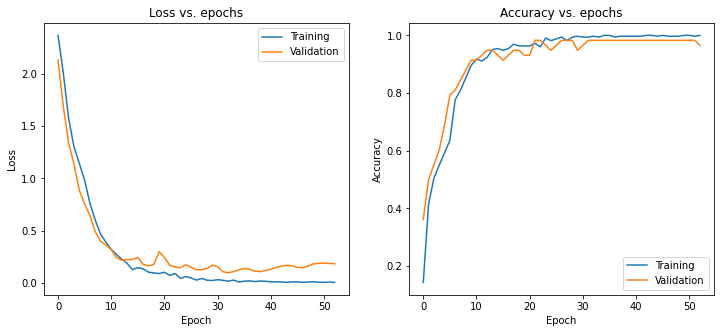

---Testing stage---
speaker1 - test loss : 0.031 - test accuracy : 0.982
----------
speaker2 - test loss : 15.840 - test accuracy : 0.144
----------
speaker3 - test loss : 5.229 - test accuracy : 0.439
----------
speaker4 - test loss : 9.437 - test accuracy : 0.240
----------
speaker5 - test loss : 3.064 - test accuracy : 0.636
----------
speaker6 - test loss : 13.779 - test accuracy : 0.236
----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1736, 400, 13, 1)
labels shape : (1736, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape :

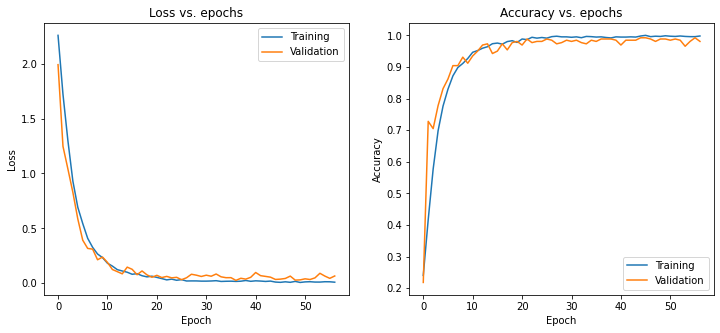

---Testing stage---
speaker1 - test loss : 0.017 - test accuracy : 0.994
Threshold : 0.5


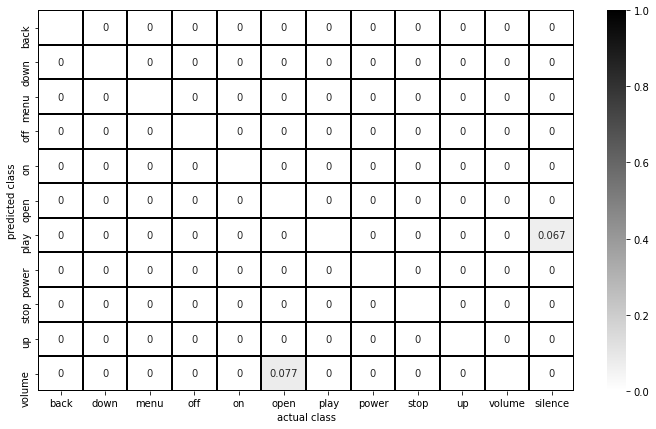

Threshold : 0.6


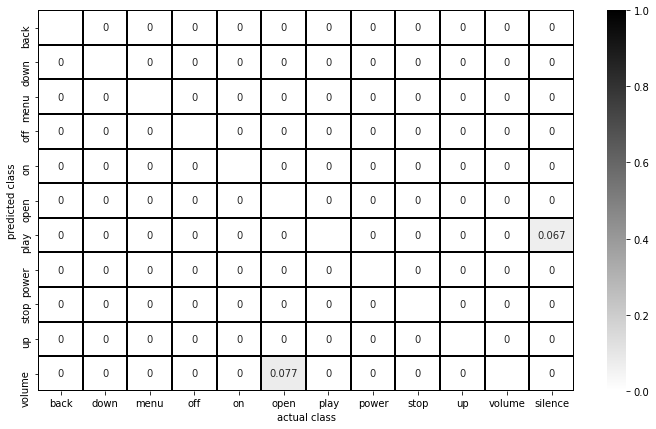

Threshold : 0.7


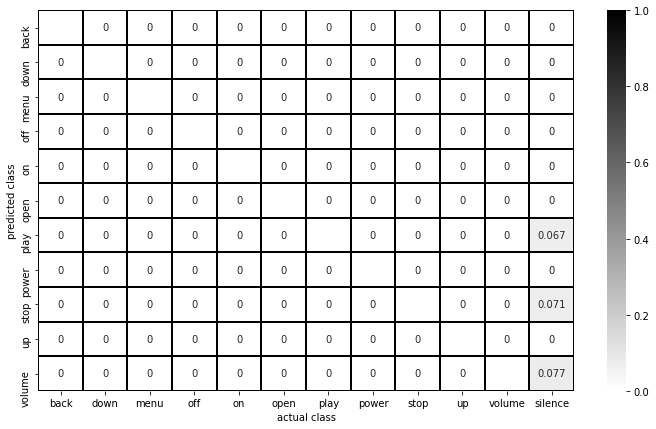

Threshold : 0.8


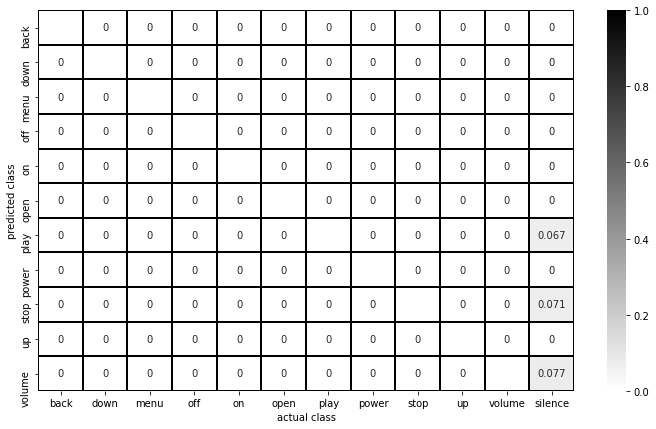

----------
speaker2 - test loss : 0.044 - test accuracy : 0.985
Threshold : 0.5


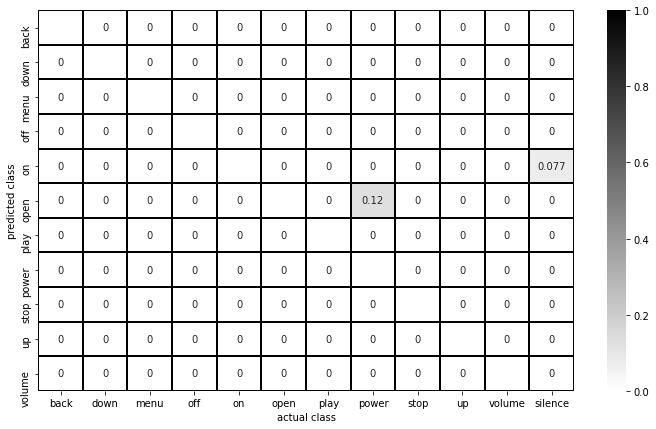

Threshold : 0.6


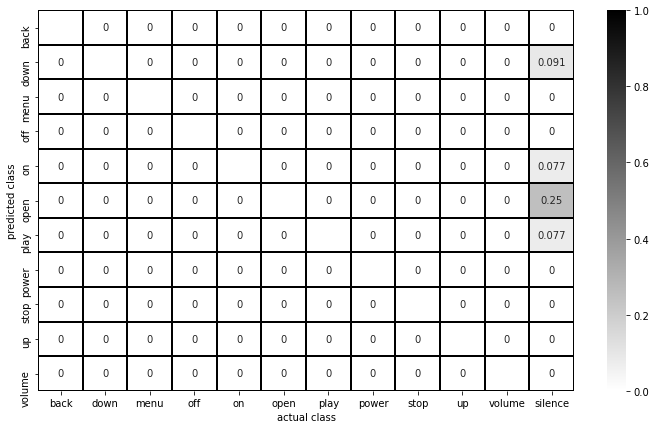

Threshold : 0.7


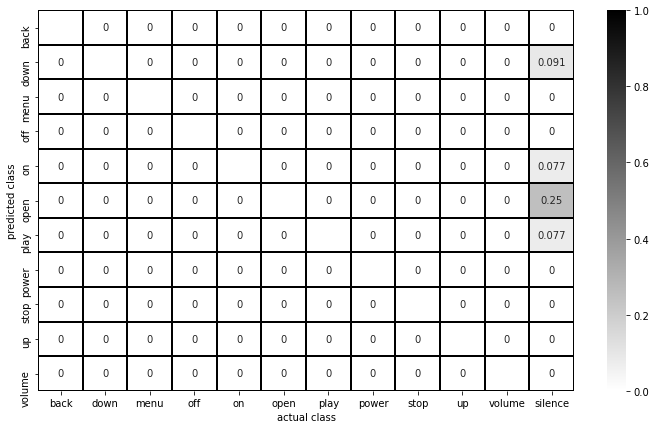

Threshold : 0.8


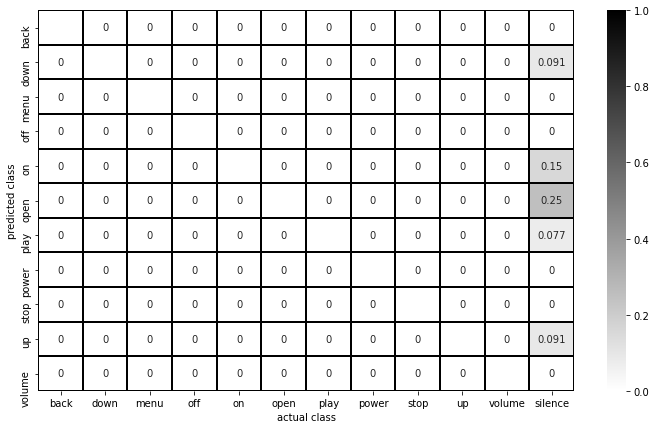

----------
speaker3 - test loss : 0.013 - test accuracy : 0.992
Threshold : 0.5


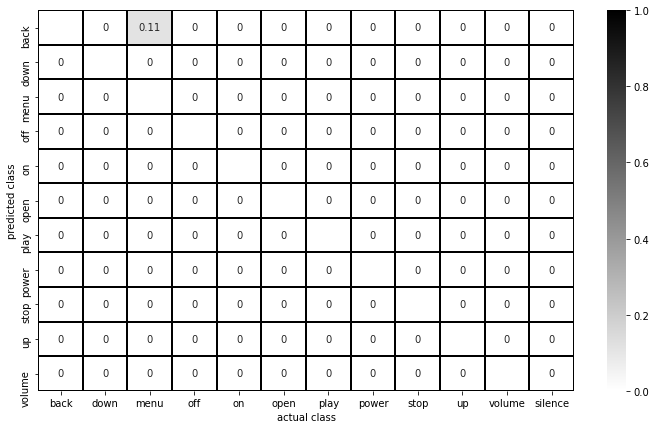

Threshold : 0.6


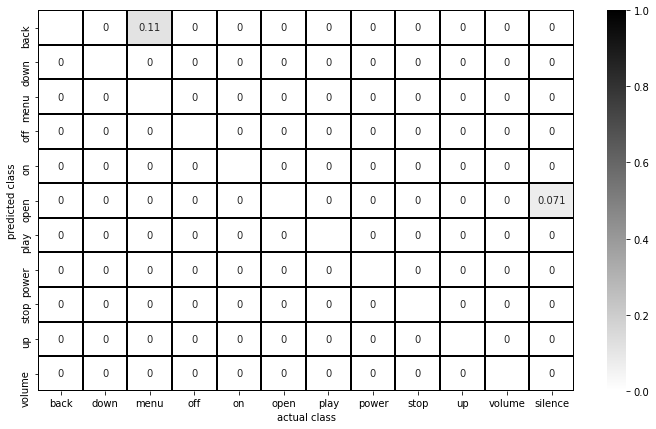

Threshold : 0.7


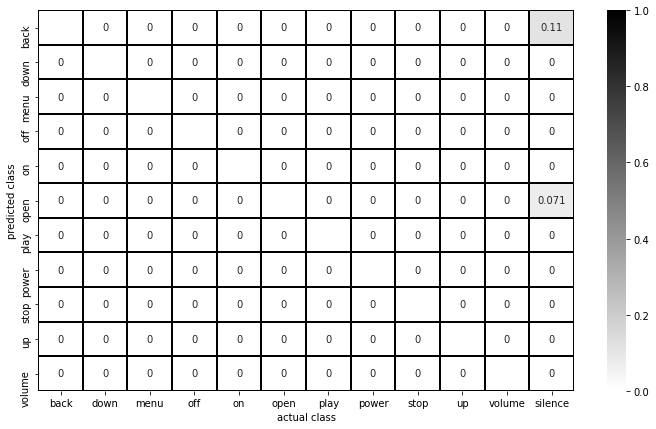

Threshold : 0.8


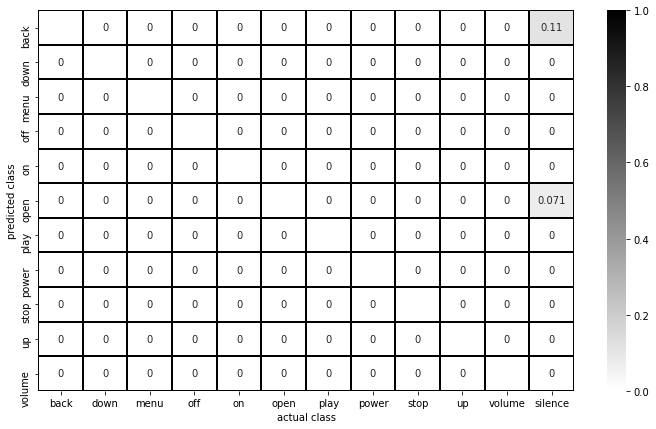

----------
speaker4 - test loss : 0.228 - test accuracy : 0.940
Threshold : 0.5


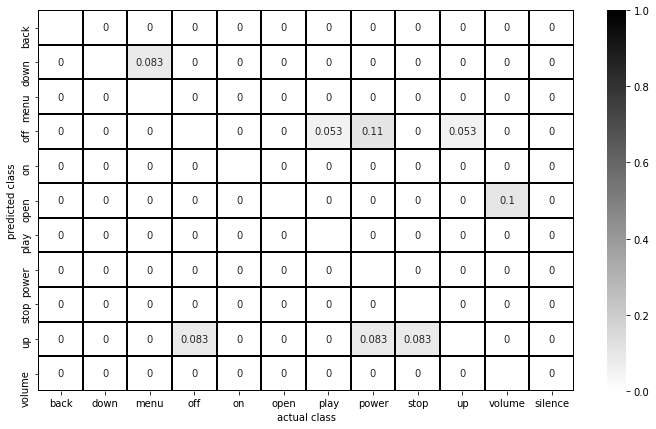

Threshold : 0.6


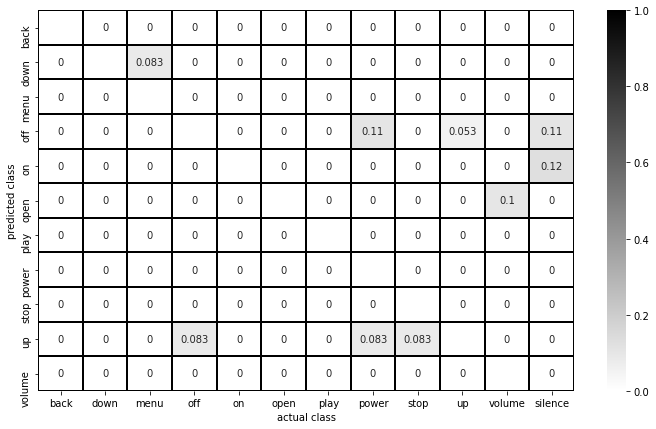

Threshold : 0.7


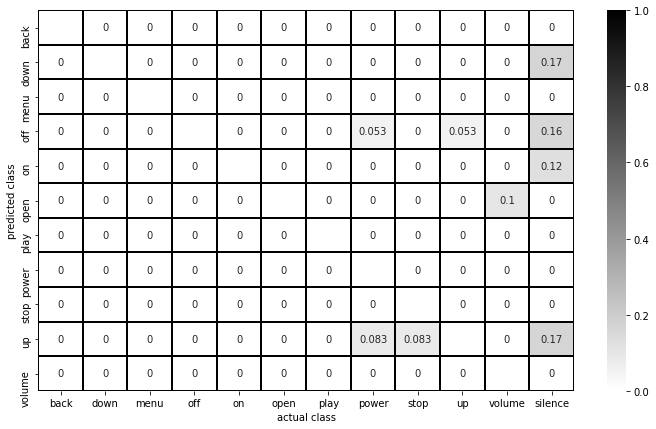

Threshold : 0.8


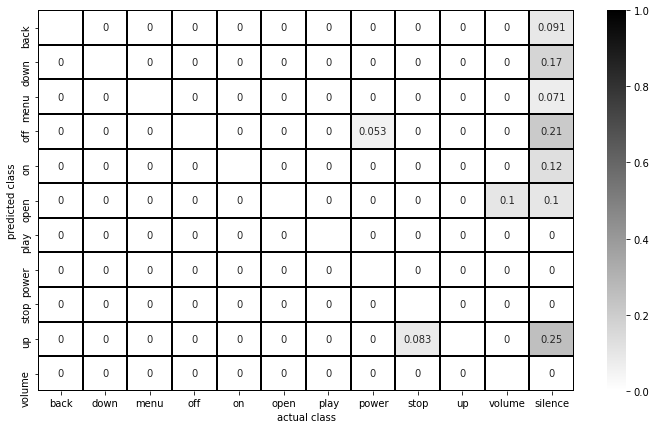

----------
speaker5 - test loss : 0.053 - test accuracy : 0.994
Threshold : 0.5


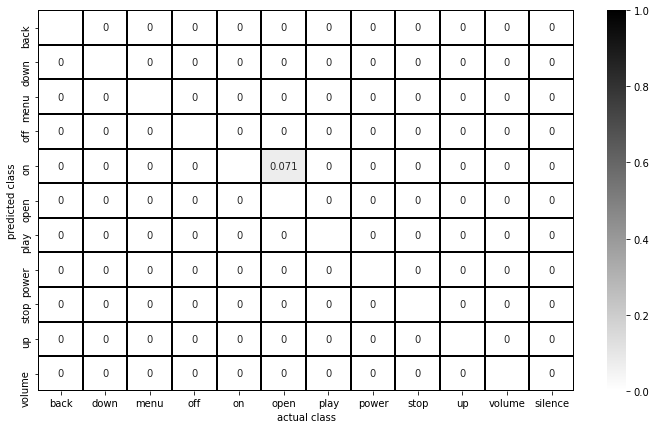

Threshold : 0.6


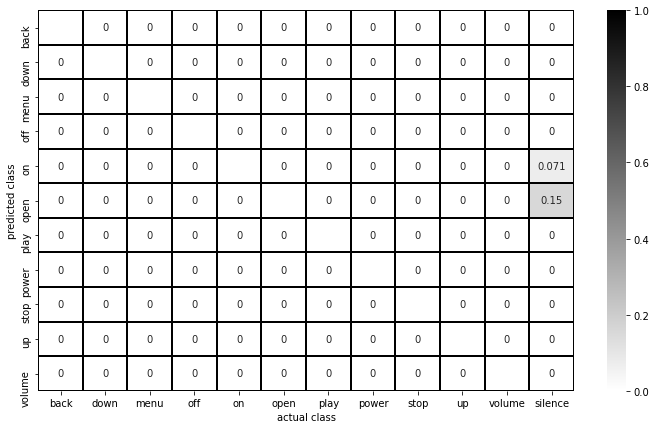

Threshold : 0.7


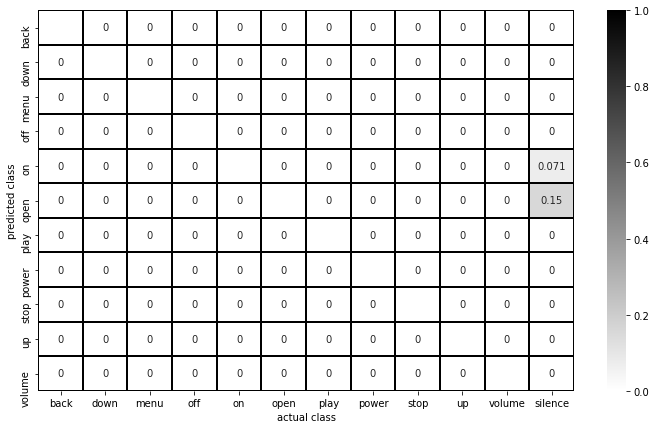

Threshold : 0.8


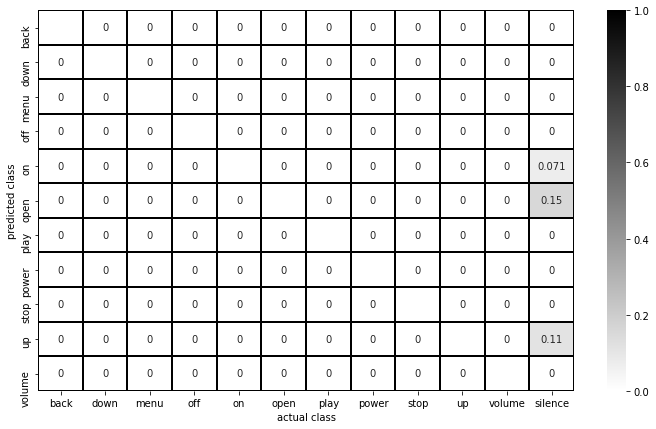

----------
speaker6 - test loss : 7.259 - test accuracy : 0.303
Threshold : 0.5


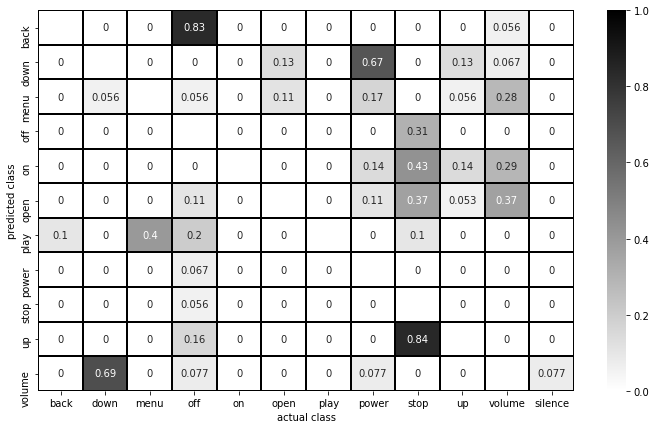

Threshold : 0.6


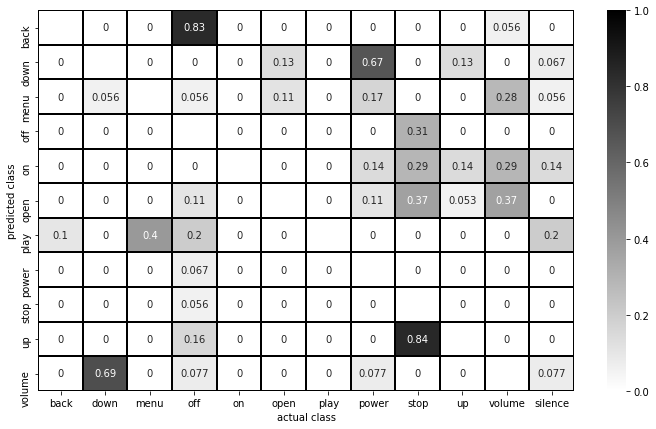

Threshold : 0.7


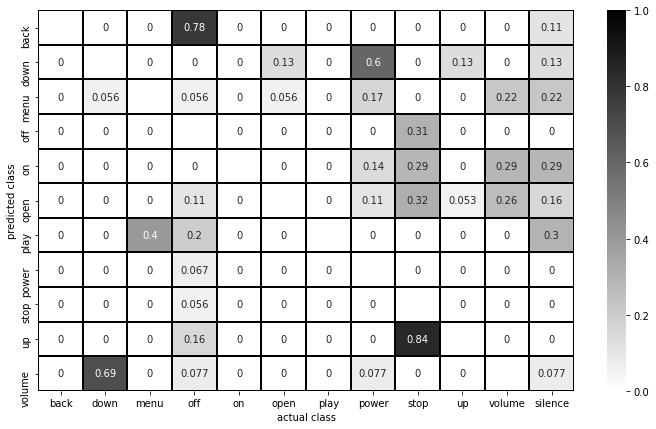

Threshold : 0.8


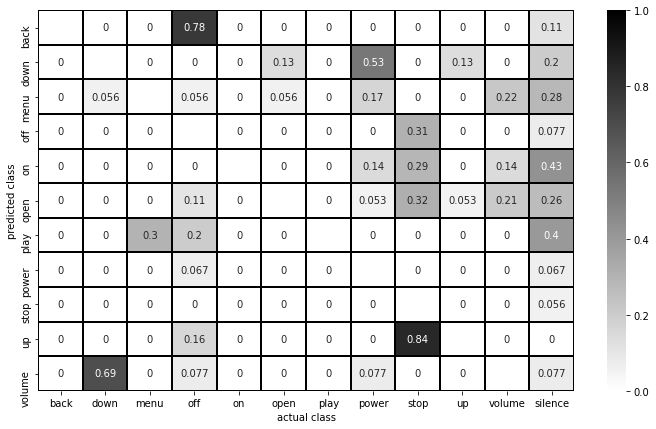

----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is cnn.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2121, 400, 13, 1)
labels shape : (2121, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (150, 400, 13, 1)
speaker4 labels shape : (150, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : 

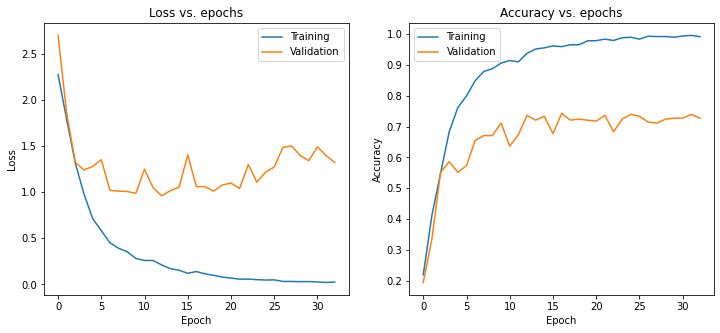

---Testing stage---
speaker1 - test loss : 0.016 - test accuracy : 0.994
Threshold : 0.5


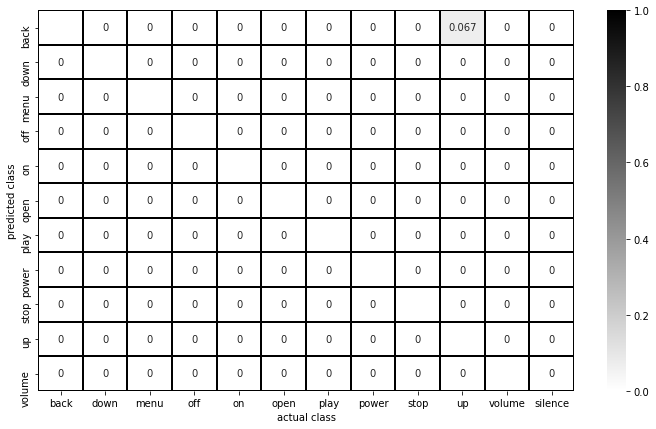

Threshold : 0.6


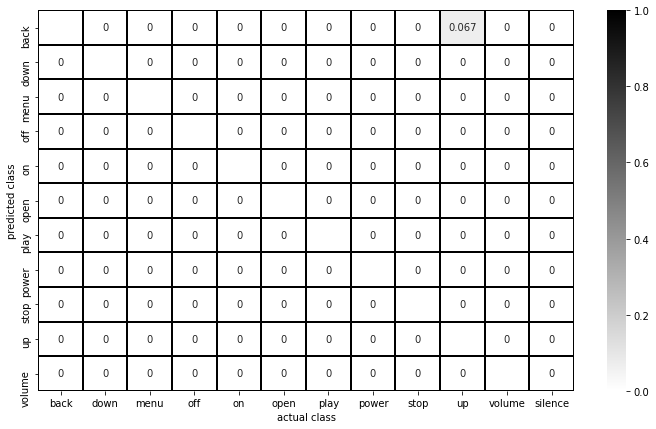

Threshold : 0.7


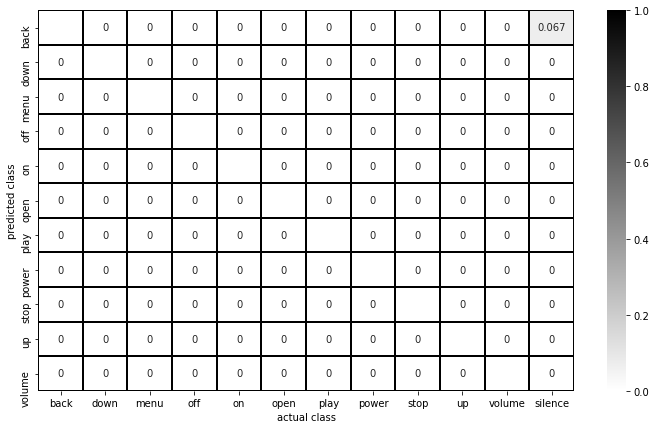

Threshold : 0.8


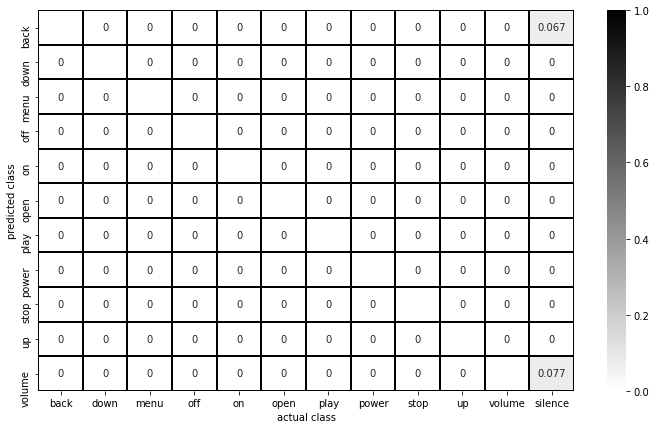

----------
speaker2 - test loss : 0.051 - test accuracy : 0.992
Threshold : 0.5


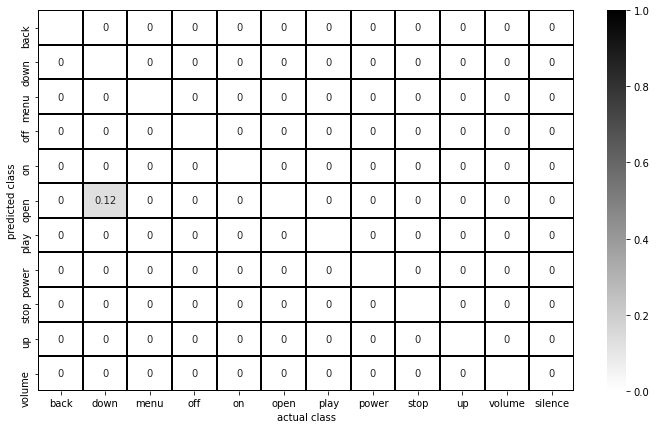

Threshold : 0.6


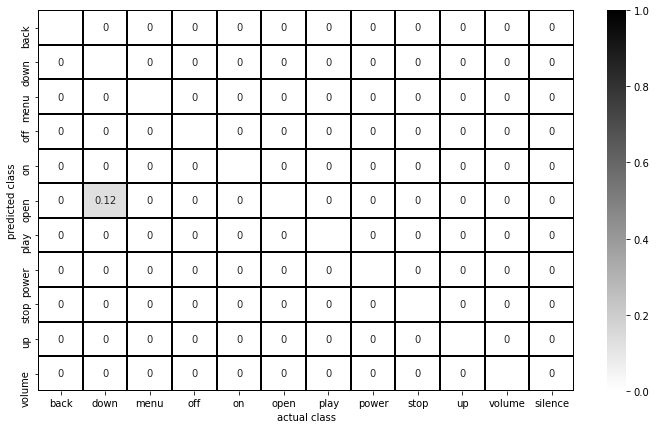

Threshold : 0.7


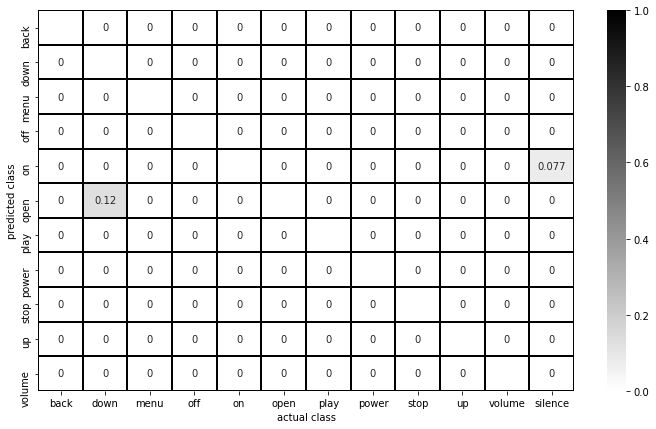

Threshold : 0.8


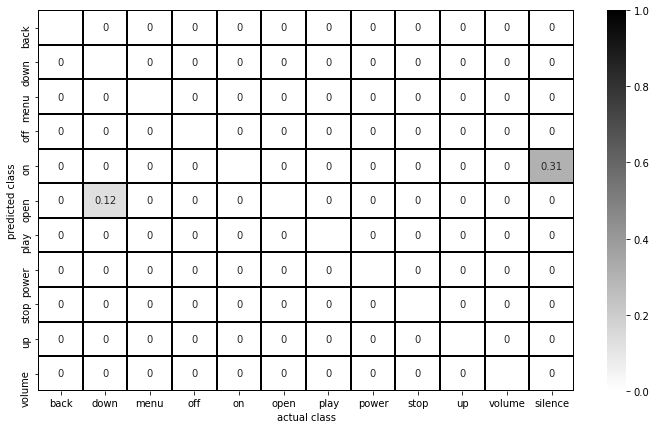

----------
speaker3 - test loss : 0.027 - test accuracy : 0.985
Threshold : 0.5


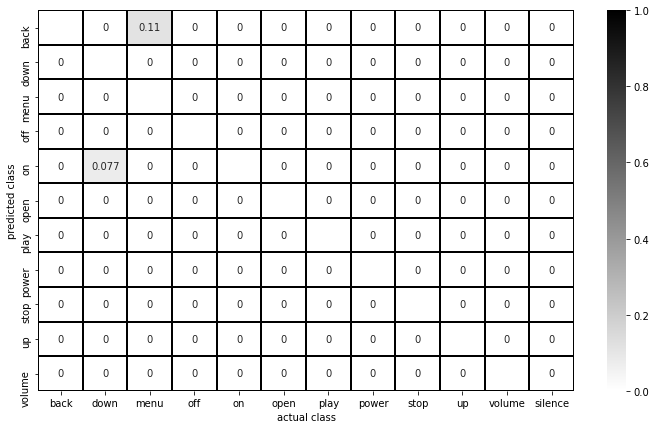

Threshold : 0.6


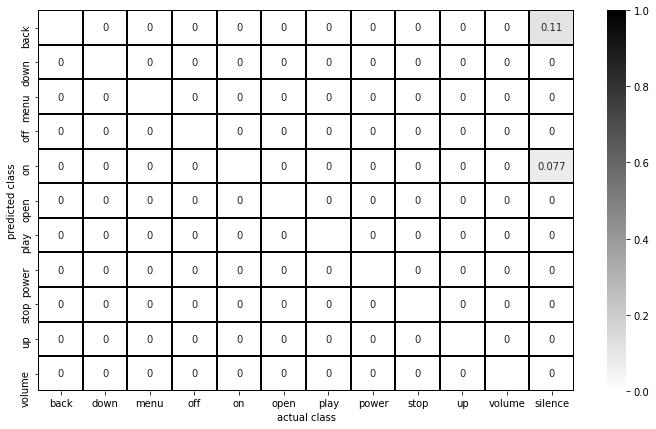

Threshold : 0.7


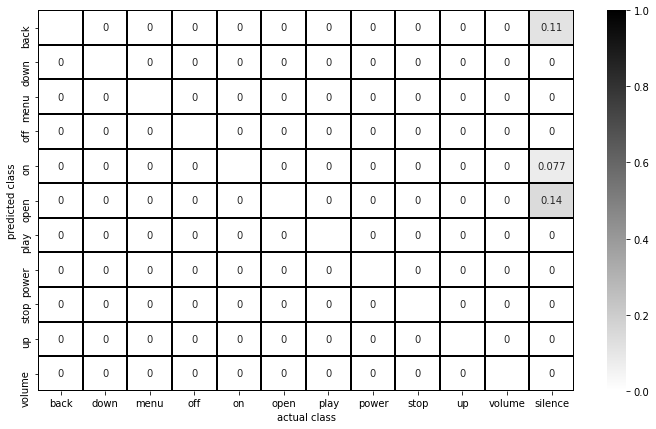

Threshold : 0.8


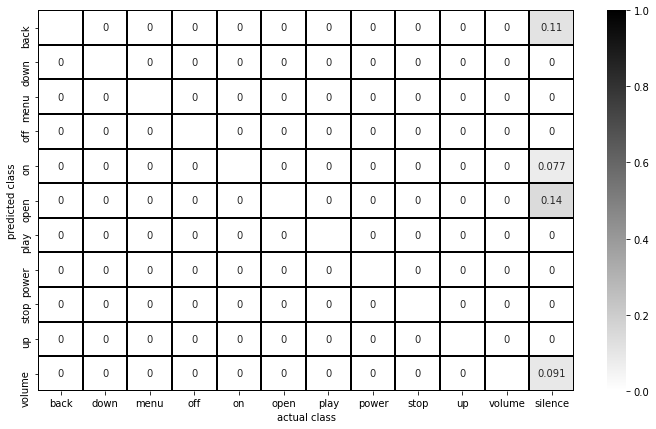

----------
speaker4 - test loss : 0.294 - test accuracy : 0.927
Threshold : 0.5


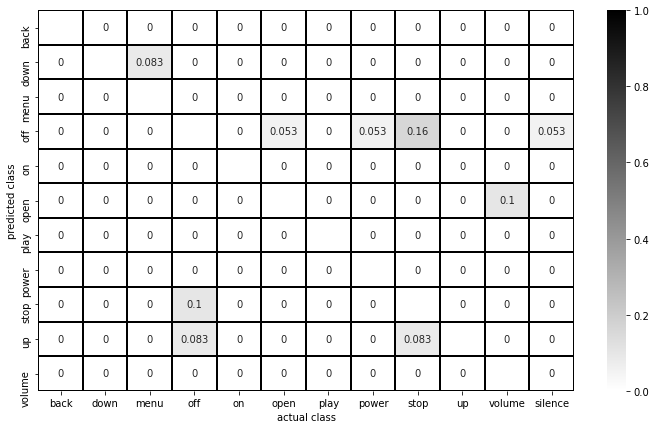

Threshold : 0.6


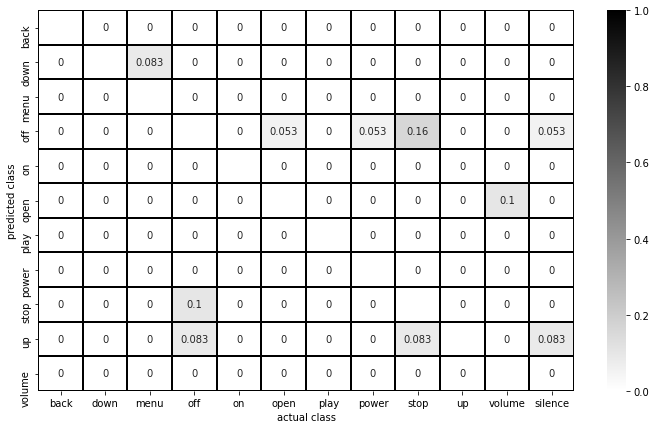

Threshold : 0.7


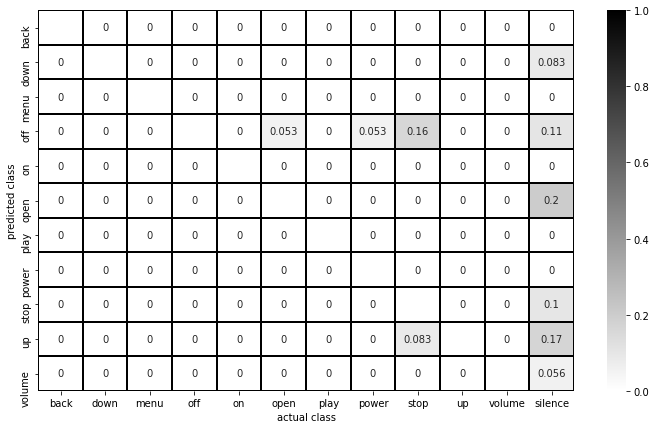

Threshold : 0.8


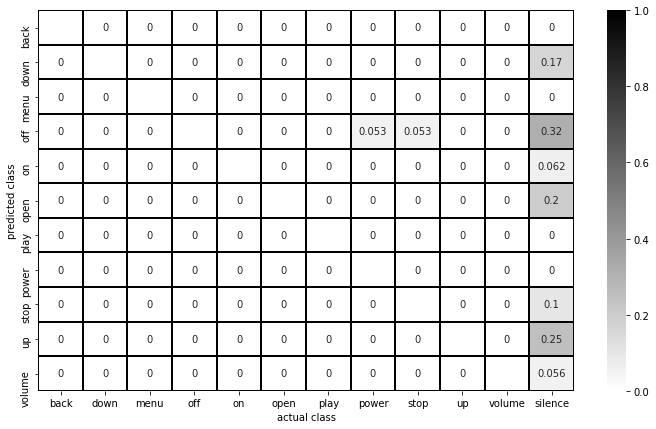

----------
speaker5 - test loss : 0.056 - test accuracy : 0.994
Threshold : 0.5


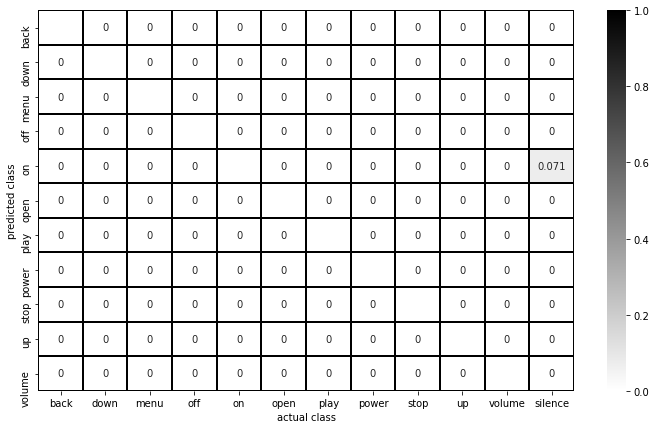

Threshold : 0.6


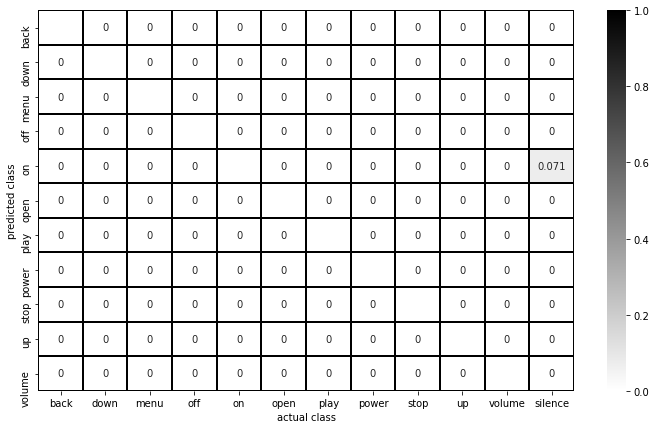

Threshold : 0.7


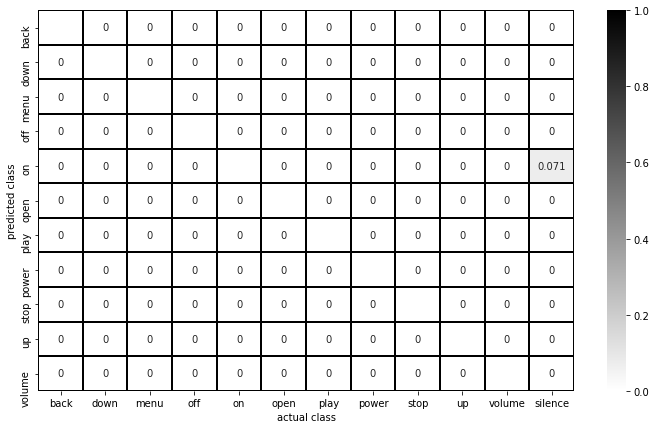

Threshold : 0.8


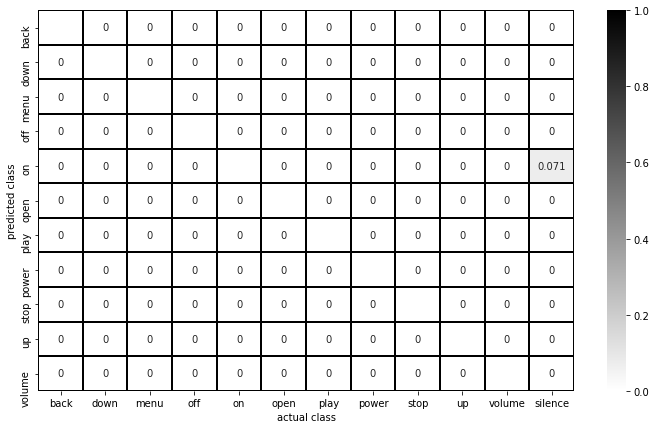

----------
speaker6 - test loss : 1.176 - test accuracy : 0.770
Threshold : 0.5


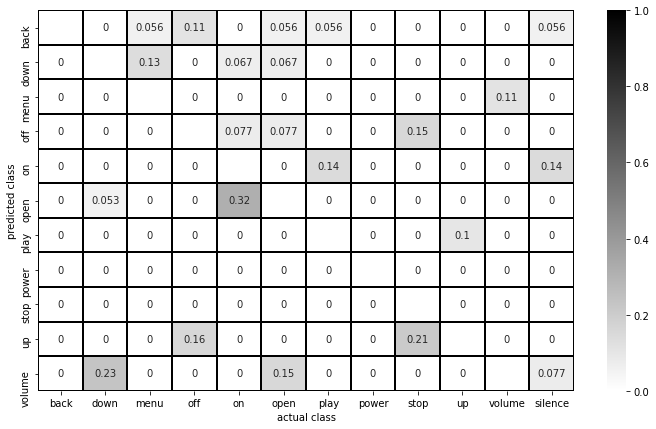

Threshold : 0.6


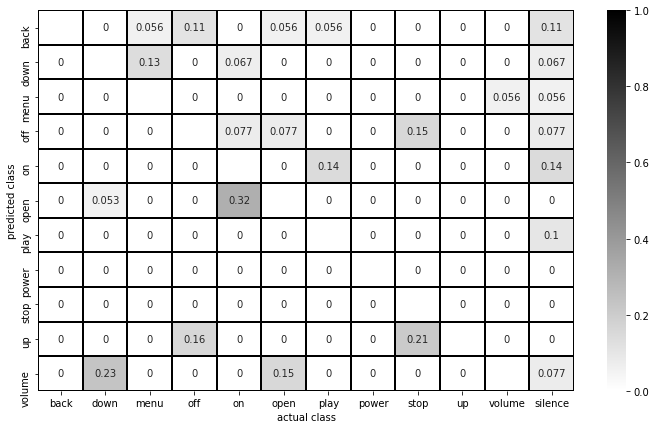

Threshold : 0.7


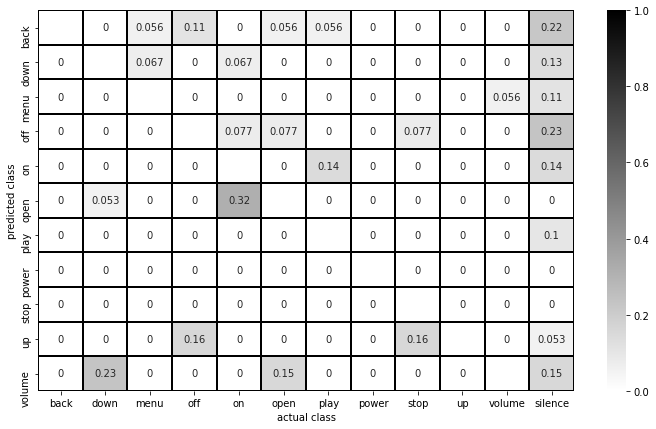

Threshold : 0.8


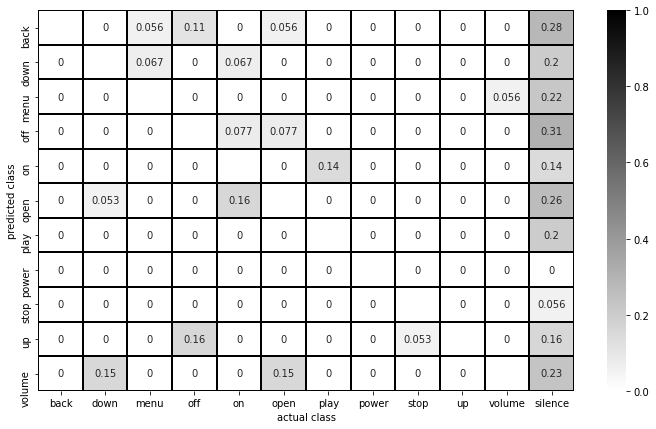

----------
Finished experiment.
Running experiment with speakers : ['speaker1'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1']
data shape : (385, 400, 13, 1)
labels shape : (385, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (150, 400, 13, 1)
speaker4 labels shape : (150, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : (165, 11)
Model: "sequential_3"
_________________________________________________________________
Layer (type)            

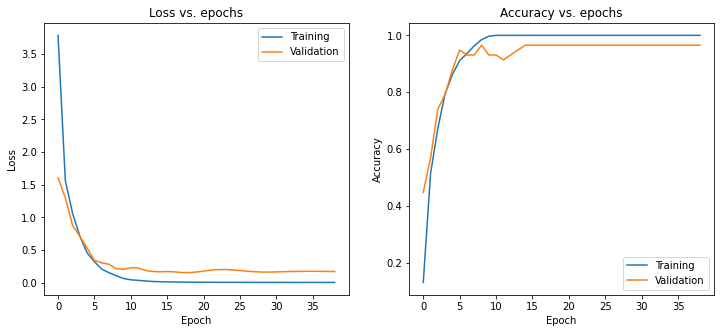

---Testing stage---
speaker1 - test loss : 0.090 - test accuracy : 0.982
----------
speaker2 - test loss : 7.244 - test accuracy : 0.174
----------
speaker3 - test loss : 3.367 - test accuracy : 0.318
----------
speaker4 - test loss : 6.850 - test accuracy : 0.300
----------
speaker5 - test loss : 4.287 - test accuracy : 0.509
----------
speaker6 - test loss : 9.818 - test accuracy : 0.121
----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5']
data shape : (1736, 400, 13, 1)
labels shape : (1736, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (

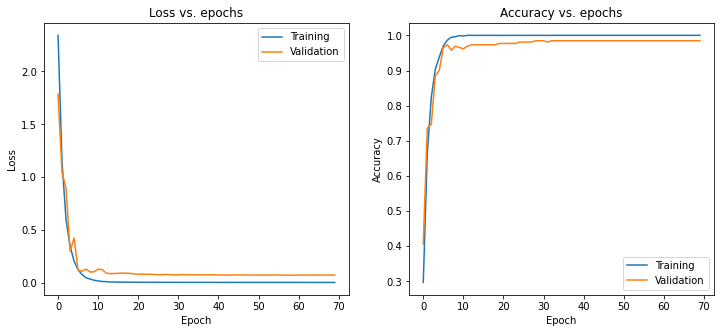

---Testing stage---
speaker1 - test loss : 0.068 - test accuracy : 0.982
Threshold : 0.5


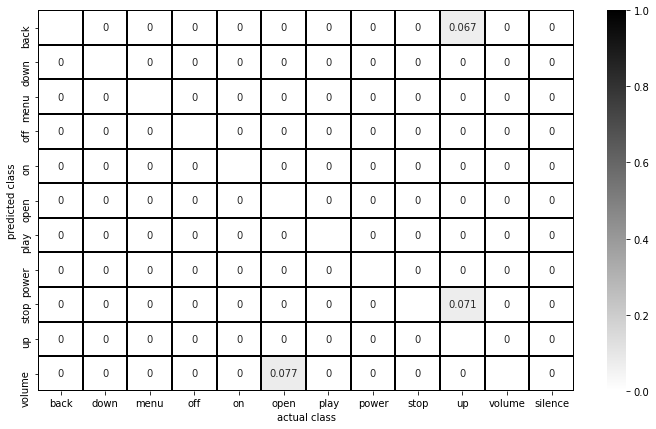

Threshold : 0.6


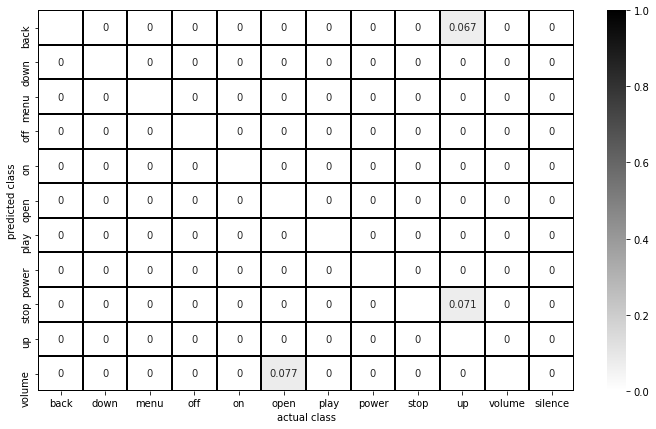

Threshold : 0.7


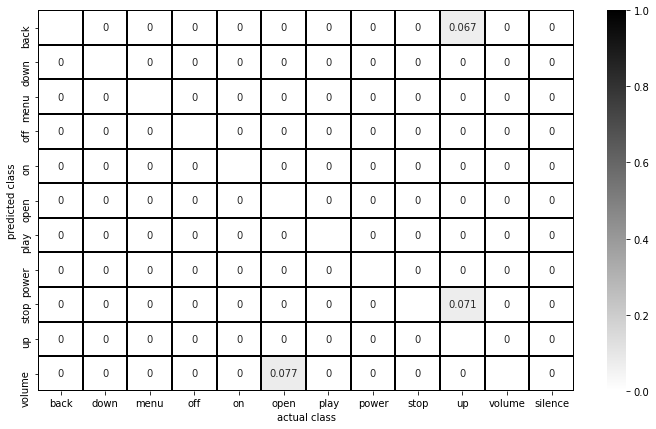

Threshold : 0.8


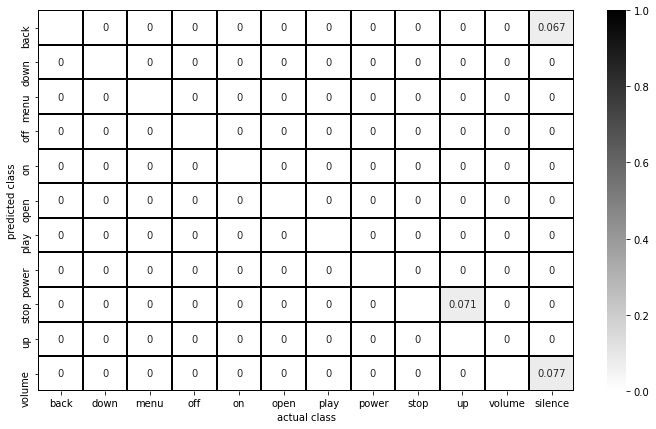

----------
speaker2 - test loss : 0.164 - test accuracy : 0.939
Threshold : 0.5


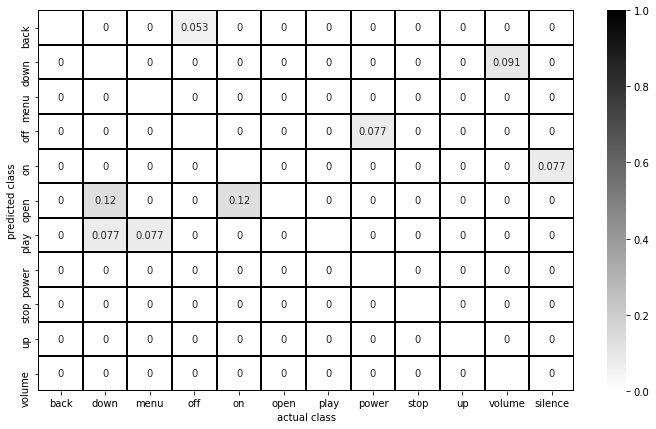

Threshold : 0.6


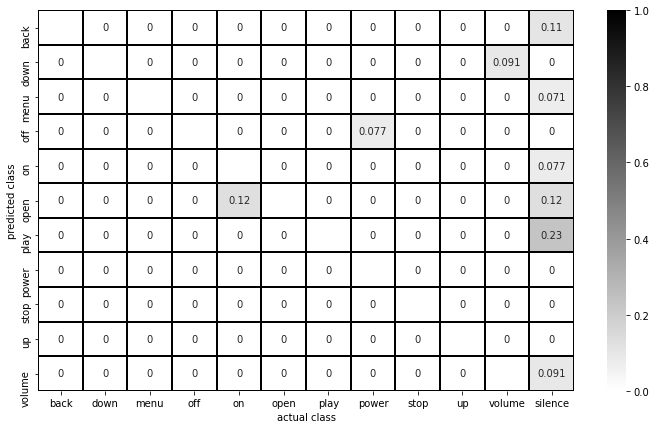

Threshold : 0.7


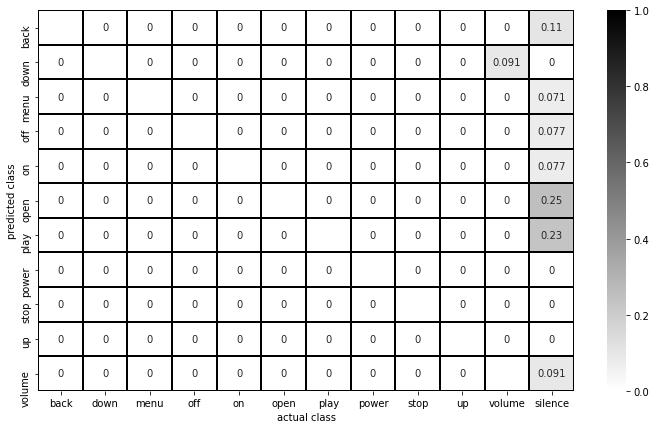

Threshold : 0.8


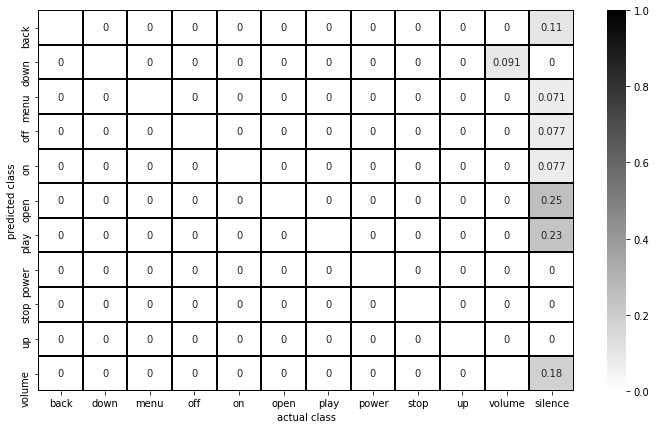

----------
speaker3 - test loss : 0.055 - test accuracy : 0.977
Threshold : 0.5


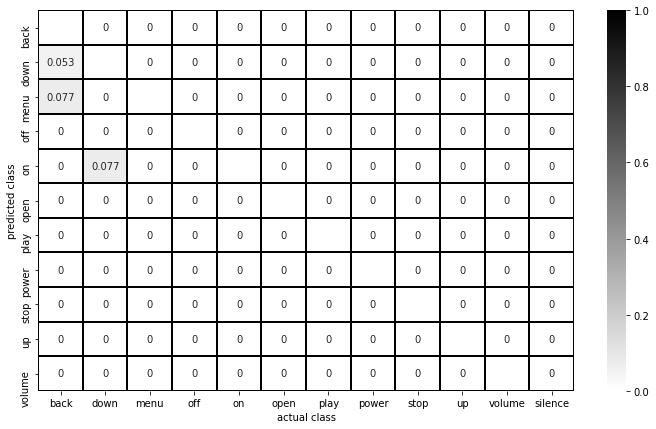

Threshold : 0.6


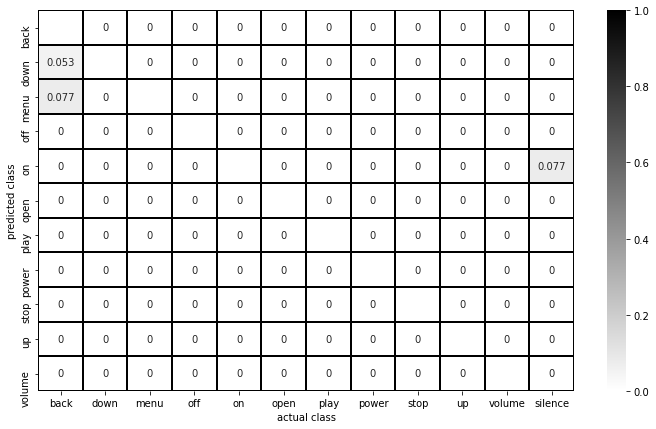

Threshold : 0.7


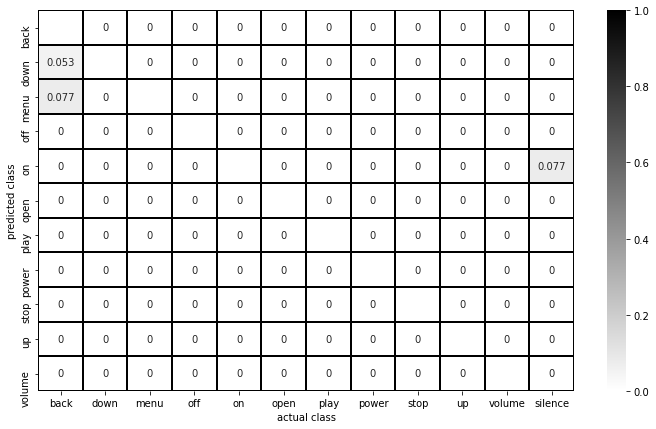

Threshold : 0.8


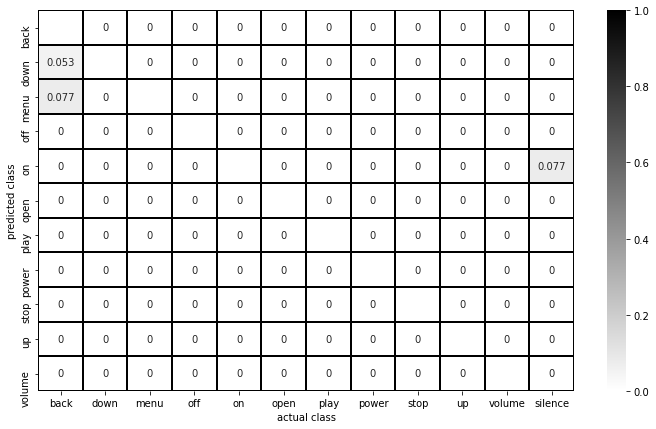

----------
speaker4 - test loss : 0.312 - test accuracy : 0.920
Threshold : 0.5


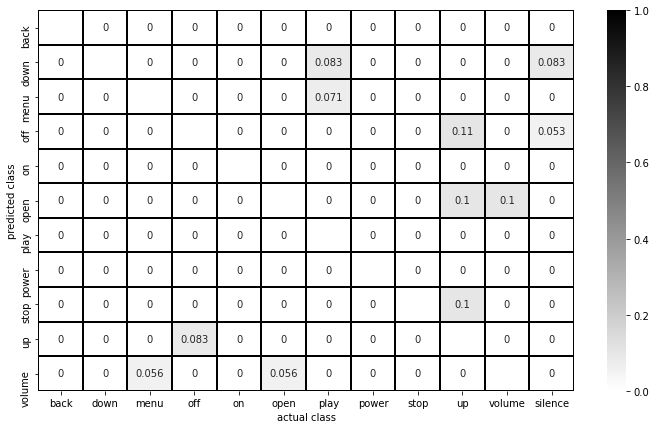

Threshold : 0.6


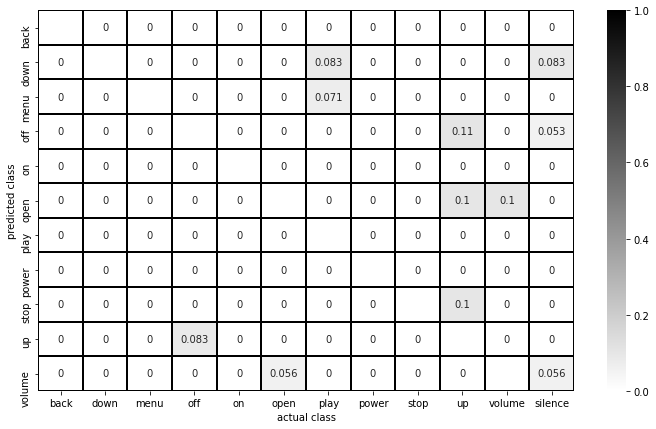

Threshold : 0.7


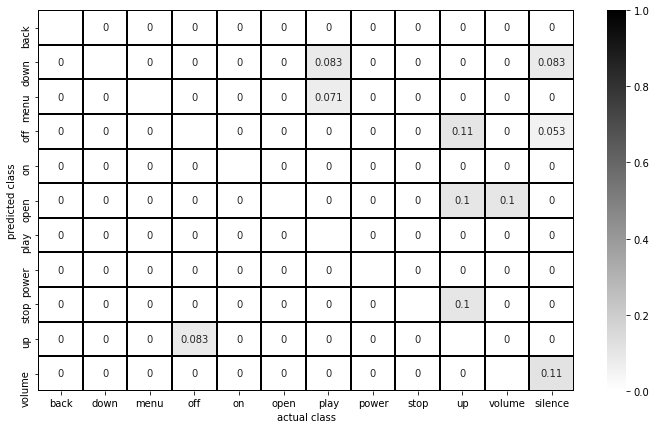

Threshold : 0.8


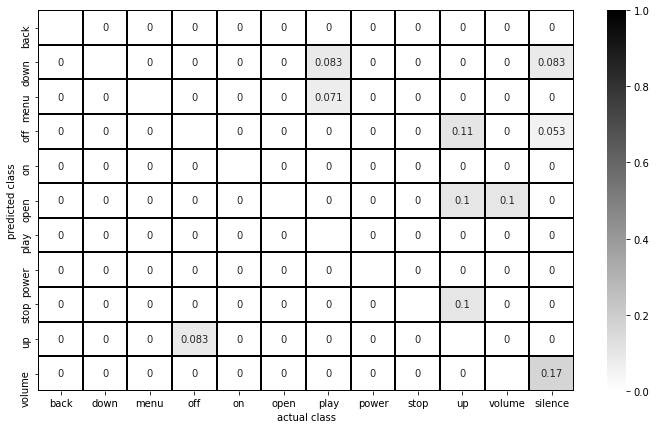

----------
speaker5 - test loss : 0.124 - test accuracy : 0.976
Threshold : 0.5


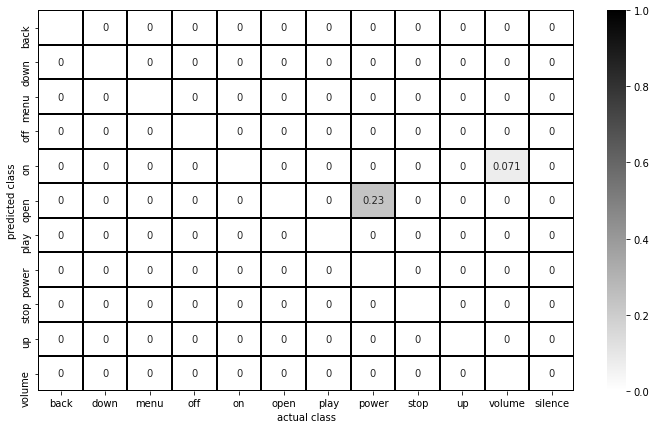

Threshold : 0.6


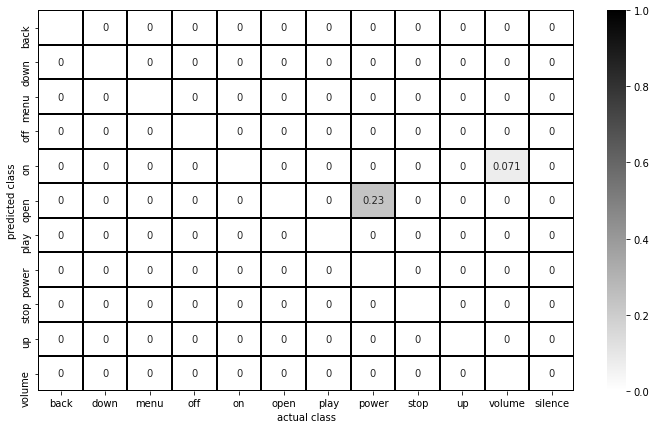

Threshold : 0.7


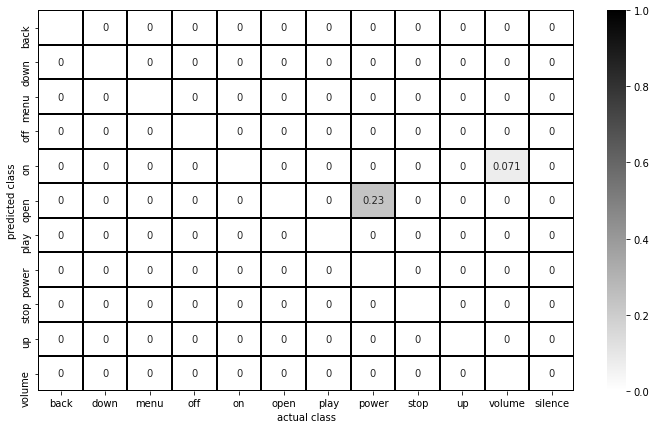

Threshold : 0.8


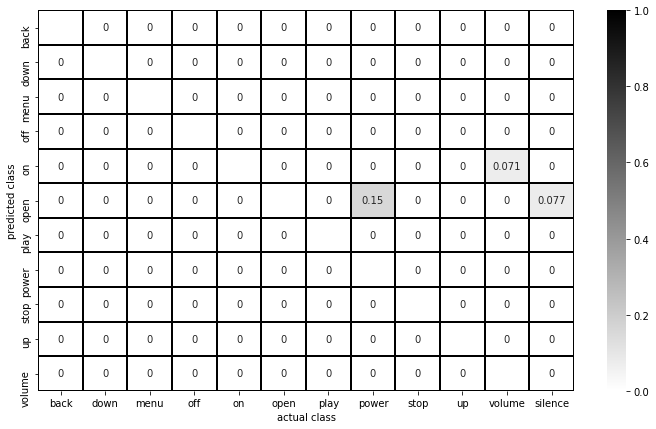

----------
speaker6 - test loss : 6.487 - test accuracy : 0.315
Threshold : 0.5


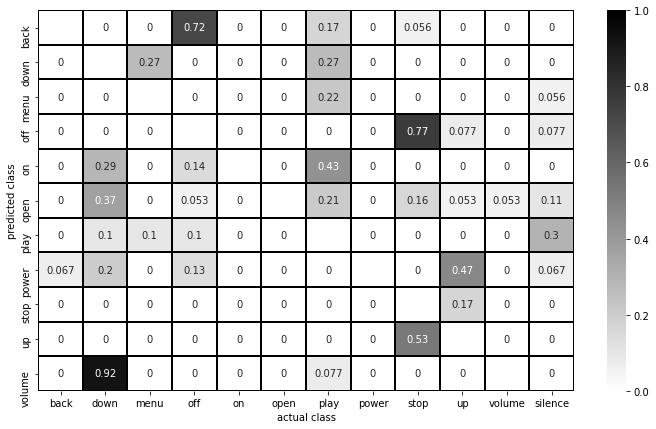

Threshold : 0.6


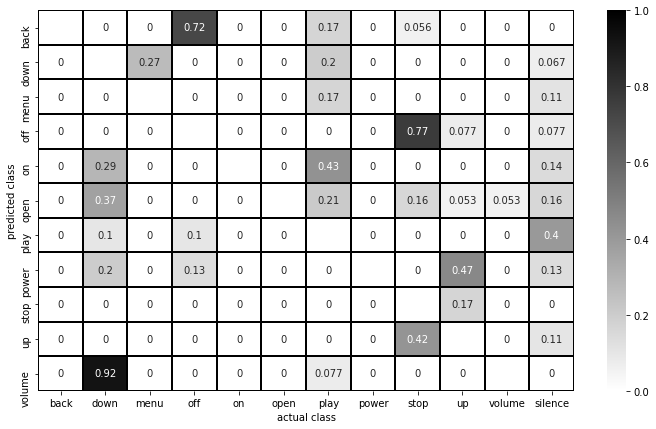

Threshold : 0.7


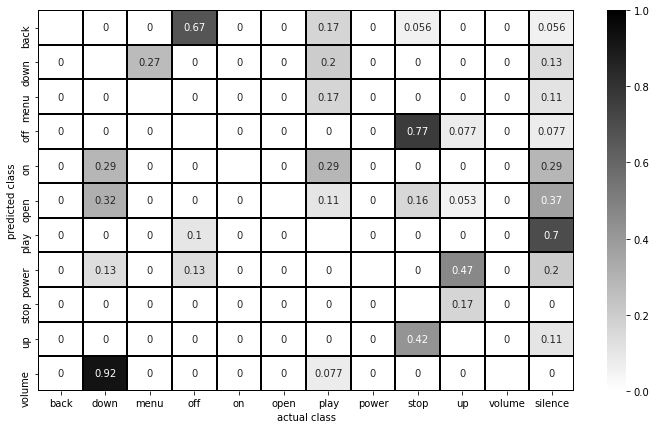

Threshold : 0.8


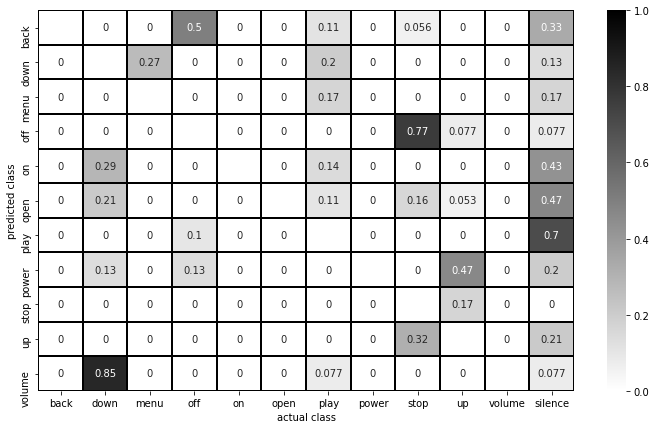

----------
Finished experiment.
Running experiment with speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as train dataset and speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6'] as test dataset. Network type is mlp.
---Train dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
data shape : (2121, 400, 13, 1)
labels shape : (2121, 11)
---Test dataset---
Contains speakers : ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
speaker1 data shape : (165, 400, 13, 1)
speaker1 labels shape : (165, 11)
speaker2 data shape : (132, 400, 13, 1)
speaker2 labels shape : (132, 11)
speaker3 data shape : (132, 400, 13, 1)
speaker3 labels shape : (132, 11)
speaker4 data shape : (150, 400, 13, 1)
speaker4 labels shape : (150, 11)
speaker5 data shape : (165, 400, 13, 1)
speaker5 labels shape : (165, 11)
speaker6 data shape : (165, 400, 13, 1)
speaker6 labels shape : 

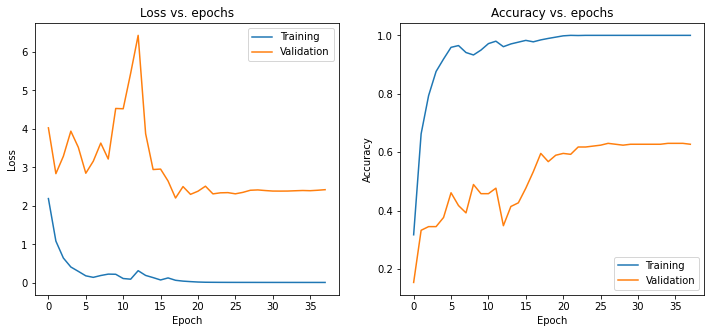

---Testing stage---
speaker1 - test loss : 0.053 - test accuracy : 0.982
Threshold : 0.5


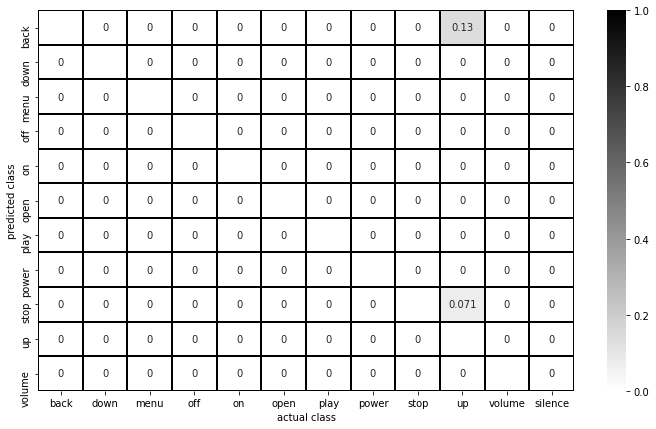

Threshold : 0.6


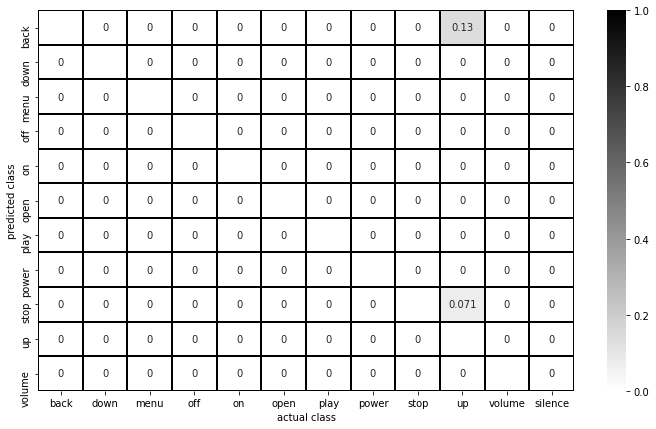

Threshold : 0.7


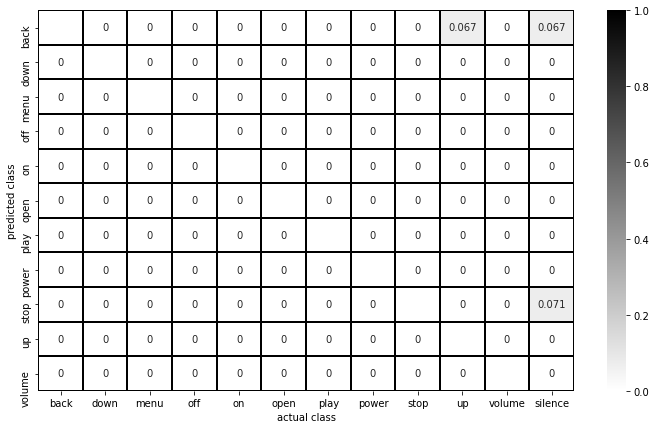

Threshold : 0.8


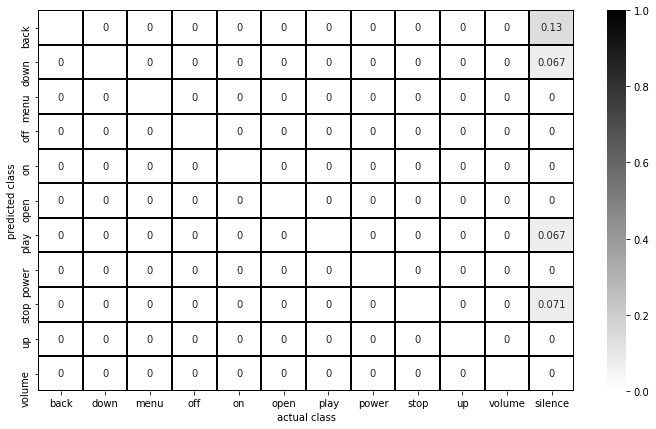

----------
speaker2 - test loss : 0.216 - test accuracy : 0.909
Threshold : 0.5


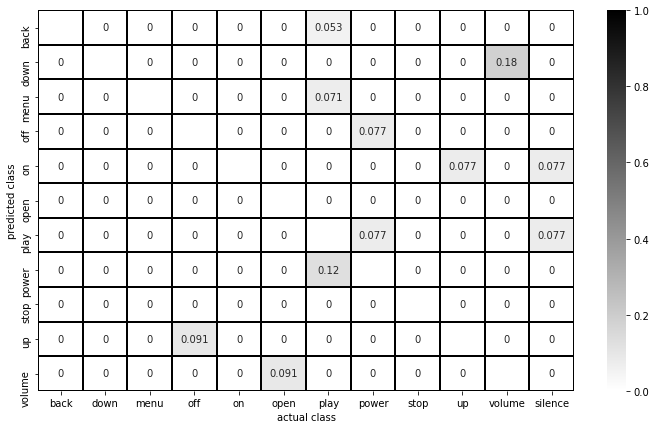

Threshold : 0.6


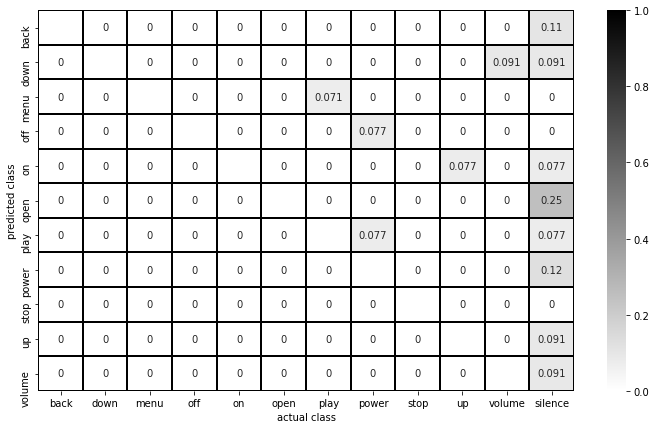

Threshold : 0.7


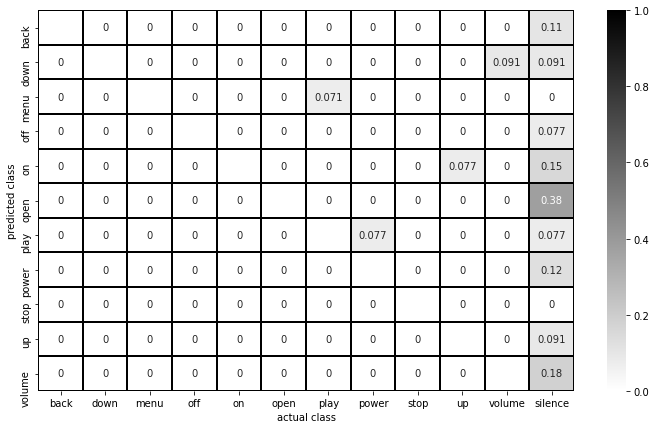

Threshold : 0.8


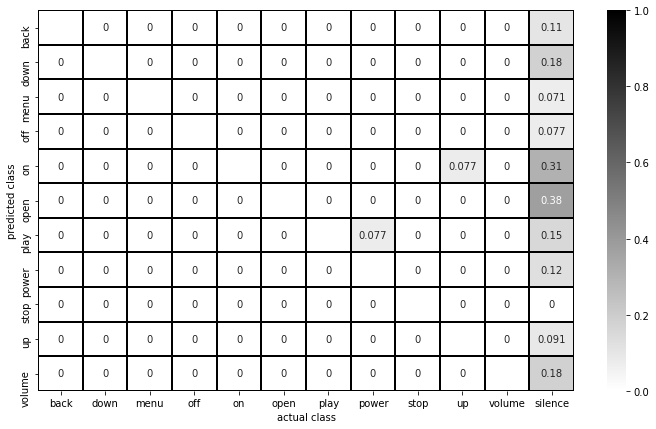

----------
speaker3 - test loss : 0.031 - test accuracy : 0.992
Threshold : 0.5


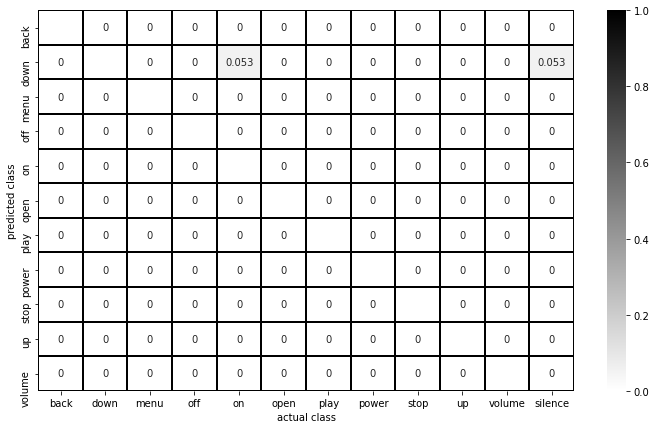

Threshold : 0.6


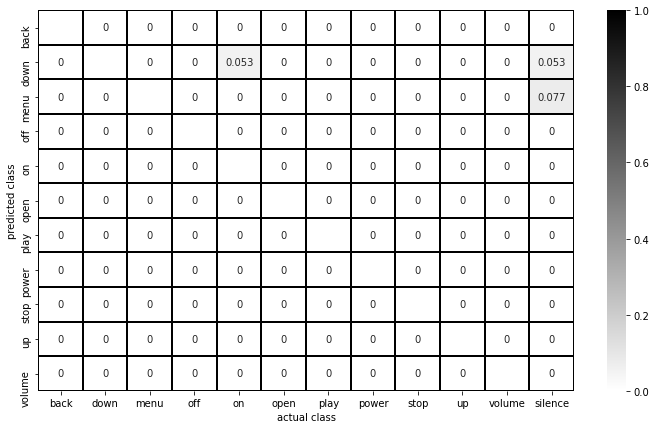

Threshold : 0.7


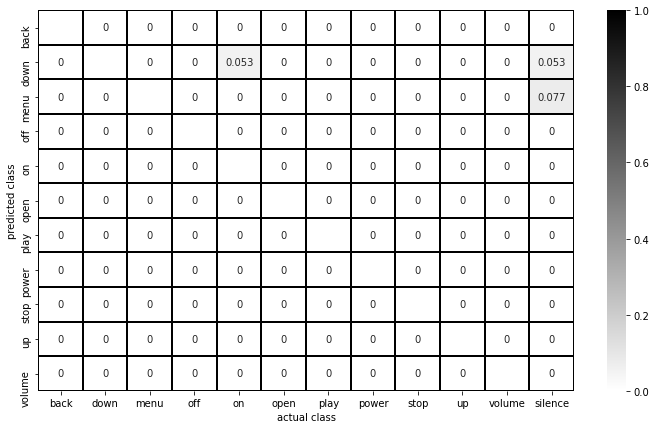

Threshold : 0.8


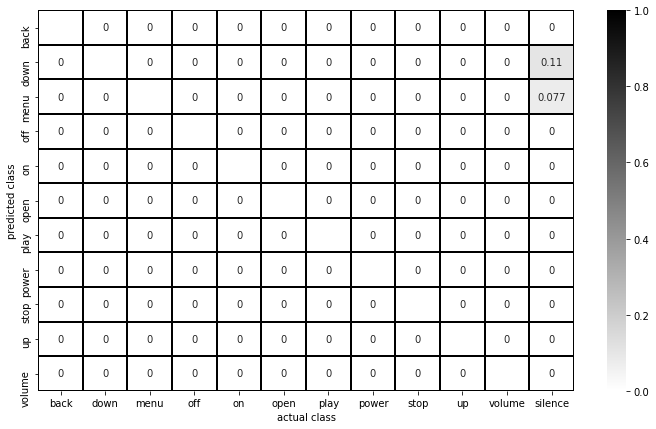

----------
speaker4 - test loss : 0.247 - test accuracy : 0.947
Threshold : 0.5


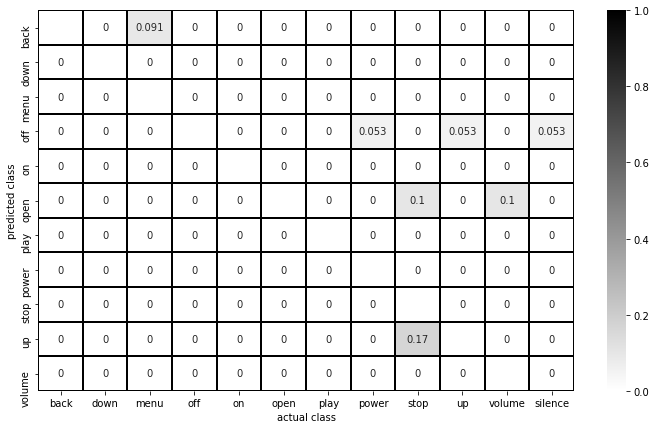

Threshold : 0.6


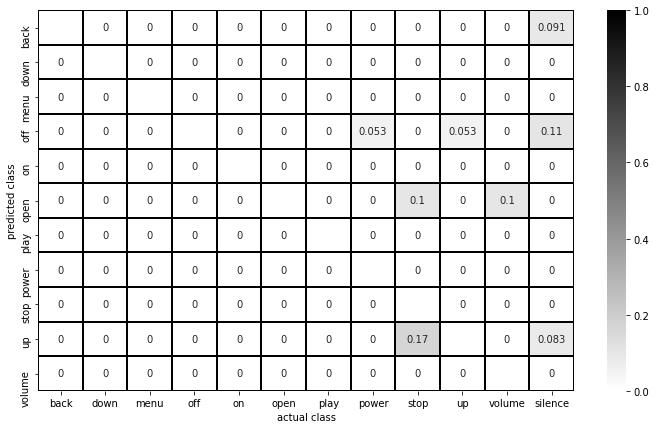

Threshold : 0.7


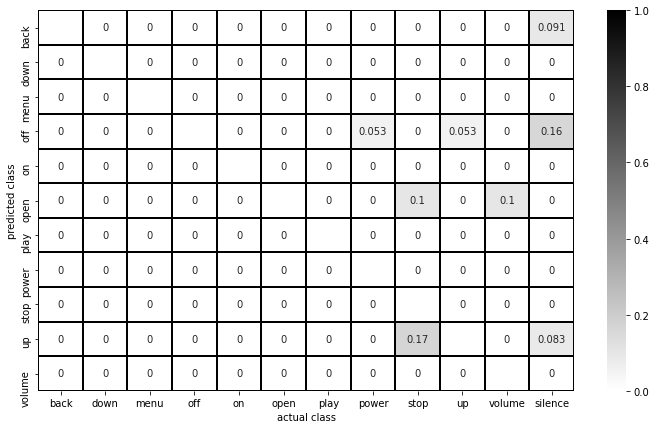

Threshold : 0.8


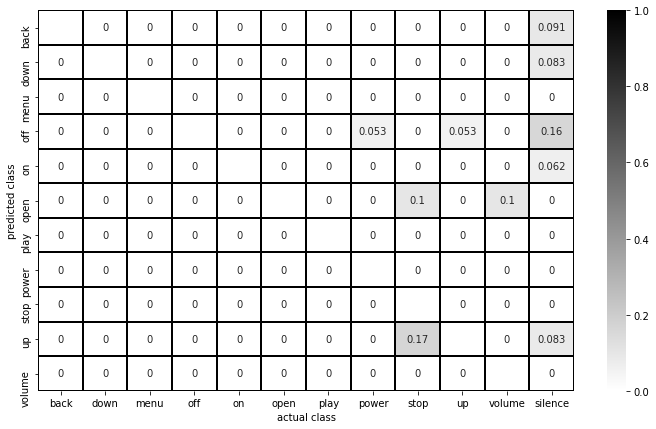

----------
speaker5 - test loss : 0.043 - test accuracy : 0.994
Threshold : 0.5


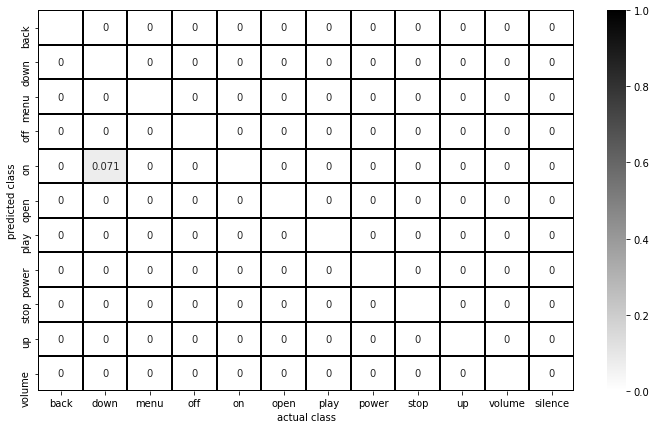

Threshold : 0.6


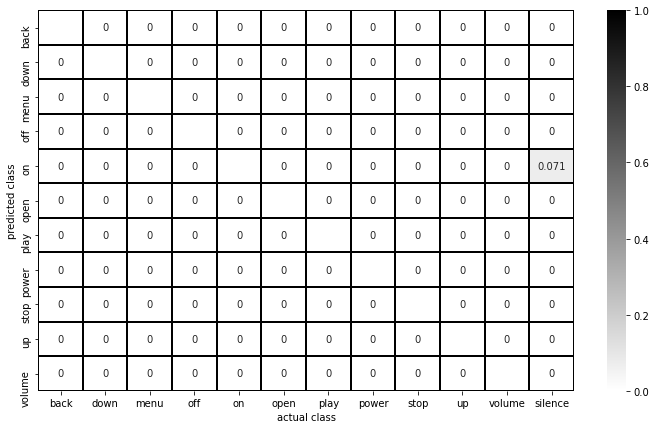

Threshold : 0.7


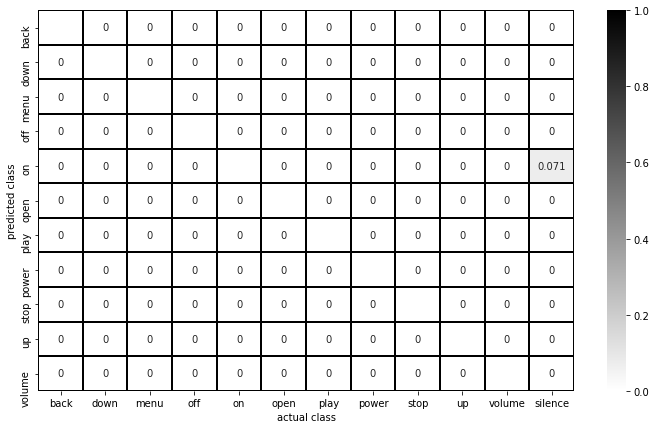

Threshold : 0.8


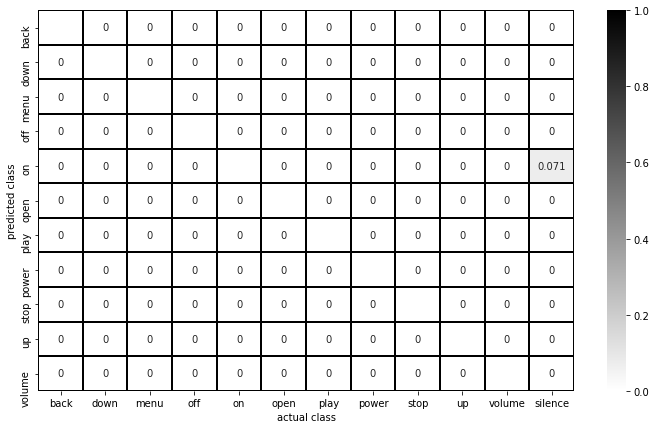

----------
speaker6 - test loss : 2.390 - test accuracy : 0.612
Threshold : 0.5


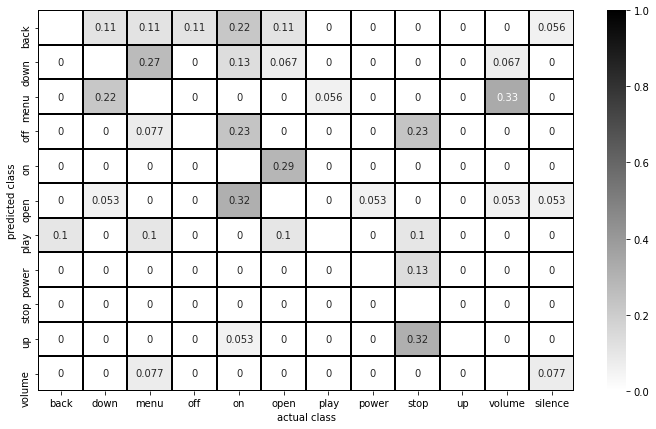

Threshold : 0.6


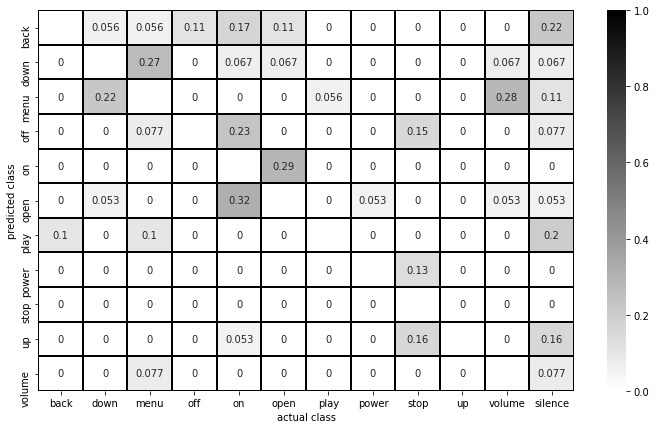

Threshold : 0.7


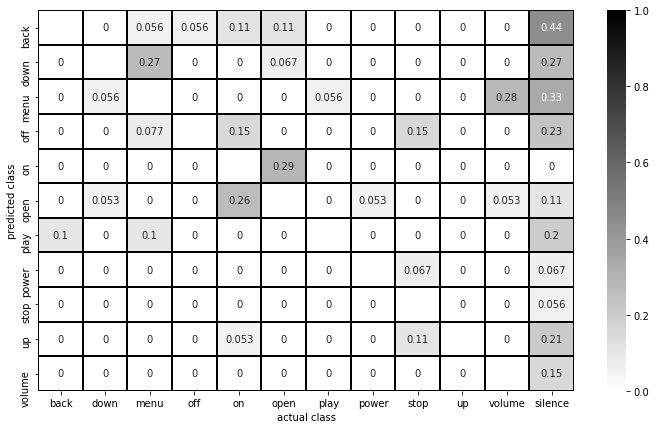

Threshold : 0.8


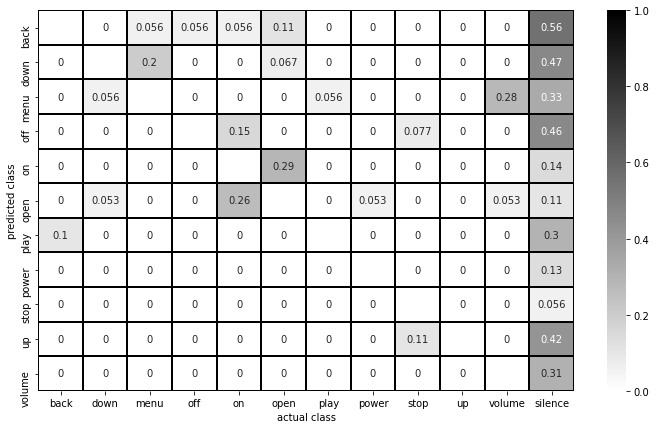

----------
Finished experiment.


In [8]:
for nn_type in ['cnn', 'mlp']:
    run_experiment(['speaker1'], all_speakers, nn_type, threshold_list, False)
    run_experiment(['speaker1','speaker2','speaker3','speaker4','speaker5'], all_speakers, nn_type, threshold_list)
    run_experiment(all_speakers, all_speakers, nn_type, threshold_list)

In [14]:
cols = ['nn_type', 'train_data', 'test_speaker', 'loss', 'accuracy']
idx = [f'experiment{i}' for i in range(len(test_summary))]
df = pd.DataFrame(test_summary, columns=cols)
print(df.to_string())

   nn_type                                                    train_data test_speaker    loss  accuracy
0      cnn                                                    [speaker1]     speaker1   0.031     0.982
1      cnn                                                    [speaker1]     speaker2  15.840     0.144
2      cnn                                                    [speaker1]     speaker3   5.229     0.439
3      cnn                                                    [speaker1]     speaker4   9.437     0.240
4      cnn                                                    [speaker1]     speaker5   3.064     0.636
5      cnn                                                    [speaker1]     speaker6  13.779     0.236
6      cnn            [speaker1, speaker2, speaker3, speaker4, speaker5]     speaker1   0.017     0.994
7      cnn            [speaker1, speaker2, speaker3, speaker4, speaker5]     speaker2   0.044     0.985
8      cnn            [speaker1, speaker2, speaker3, speaker4, s